## Atlas subset of T cells

We are subsetting to T cells and performing a simple clustering analyis on the unintegrated space.

__created__ = "2024-06-24 Mon 11:23:47 BST" 

__updated__ = "2024-06-24"

__version__ = "0.0.9"

__status__ = "Prototype"

__copyright__ = "Copyright 2024-06-24, The Wellcome Sanger Institute"

__license__ = "GPL"

__maintainer__ = "Ciro Ramírez-Suástegui"

__author__ = "Ciro Ramírez-Suástegui"

__email__ = "cs59@sanger.ac.uk, cramsuig@gmail.com"

#### Structure <a class="anchor" id="menu"></a>

* [Global variables and paths](#bullet1)
* [Loading data](#bullet2)
* [Pre-processing](#bullet3)
* [Main](#bullet4)
* [Conclusions](#bullet5)
* [Save](#bullet6)

### Environment setup

Dependencies: functions and packages

In [1]:
import importlib.util as importlib_util
is_pynb = importlib_util.find_spec("get_ipython")
if is_pynb is not None:
    %load_ext autoreload
    %autoreload 2

In [2]:
style = importlib_util.find_spec("lab_black")
if is_pynb is not None and style is not None:
        %load_ext lab_black

In [3]:
# basic modules
import warnings, os, sys, re, time
import inspect, pickle
import logging, yaml

In [4]:
# Script's directory
try:
    __file__
except NameError:
  temp=!echo $(pwd)
  __file__=temp[0]

In [5]:
project_dir = os.path.dirname(os.path.realpath(__file__))
if os.path.basename(project_dir) != os.path.basename(os.getcwd()):
    os.chdir(project_dir)

In [6]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [7]:
# in-house/developing modules

In [8]:
# tools modules
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.figure as mplfig # to check for Figure type

In [9]:
if is_pynb is not None:
    !echo "${HOSTNAME} | ${SLURMD_NODENAME} ${PBS_NODEFILE}"
homename = os.environ.get('USER', os.environ.get('USERNAME'))
logging.info(f'Environment: {re.sub(".*"+homename+"|.os.py", "", os.__file__)}')
logging.info(f'Working at: {re.sub(".*"+homename, "", os.getcwd())}')

### [Global variables and paths](#menu) <a class="anchor" id="bullet1"></a>

In [10]:
inputs_file = "/lustre/scratch126/cellgen/team298/ab72/CTCL/objects-new/8_CTCL+PRJ+HRA+flex_4k_5dim_100hidd_raw_flex_corrected_leiden_broad_ct.h5ad"
markers1_file = "data/markers_paper-epidermis_wang-drummond.yaml"
markers0_file = "data/markers_paper-ctcl_li-strobl-poyner.yaml"
output_dir = "results/atlas_annotation"
figure_dir = "figures/atlas_annotation"

In [11]:
OUTPUTS = dict()

#### Visualisation parameters

In [12]:
rcParams_dict = {
  "figure.figsize": (7, 7), "figure.dpi": 150, "figure.frameon": False,
  "savefig.dpi": 190, "savefig.bbox": "tight", "savefig.transparent": True
}
for i in rcParams_dict.keys():
  print(i.ljust(22, ' '), plt.rcParams[i], end=" > ")
  plt.rcParams[i] = rcParams_dict[i]
  print(plt.rcParams[i])

figure.figsize         [6.4, 4.8] > [7.0, 7.0]
figure.dpi             100.0 > 150.0
figure.frameon         True > False
savefig.dpi            figure > 190.0
savefig.bbox           None > tight
savefig.transparent    False > True


#### Scanpy settings and logging

In [13]:
sc.logging.print_versions()

-----
anndata     0.10.6
scanpy      1.10.0rc2.dev29+gc68557c5
-----
PIL                 10.3.0
asciitree           NA
asttokens           NA
cloudpickle         3.0.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
cytoolz             0.12.3
dask                2024.4.0
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.3
jedi                0.19.1
jinja2              3.1.3
joblib              1.3.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.42.0
lz4                 4.3.3
markupsafe          2.1.5
matplotlib          3.8.3
mpl_toolkits        NA
msgpack             1.0.7
natsort             8.4.0
numba               0.59.1
numcodecs           0.12.1
numpy               1.26.4
packaging           24.0
pandas              2.

In [14]:
sc.settings.figdir = figure_dir

### [Loading data](#menu) <a class="anchor" id="bullet2"></a>

In [15]:
adata = sc.read(inputs_file, backed="r")

In [16]:
adata

AnnData object with n_obs × n_vars = 419579 × 15790 backed at '/lustre/scratch126/cellgen/team298/ab72/CTCL/objects-new/8_CTCL+PRJ+HRA+flex_4k_5dim_100hidd_raw_flex_corrected_leiden_broad_ct.h5ad'
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'cell_type', 'groups1', 'groups', 'broad_ct', 'tissue'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'tech_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [17]:
with open(markers1_file, "r") as stream:
    try:
        markers1 = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

with open(markers0_file, "r") as stream:
    try:
        markers0 = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [18]:
markers1

{'Keratinocytes': ['KRT5', 'KRT14', 'KRT1', 'KRT10'],
 'Fibroblasts': ['COL1A1', 'COL1A2', 'DCN', 'FBN1'],
 'Immune Cells': ['CD3D', 'CD3E', 'CD19', 'CD79A', 'CD14', 'CD68'],
 'Melanocytes': ['PMEL', 'MLANA'],
 'Langerhans Cells': ['CD1A', 'CD207'],
 'Adipocytes': ['ADIPOQ', 'PPARG'],
 'Endothelial Cells': ['CDH5', 'PECAM1'],
 'Mesenchymal Cells': ['CD90'],
 'Merkel Cells': ['ATOH1', 'KRT20'],
 'Dendritic Cells': ['CD1C', 'CD11C'],
 'Basal Stem Cell (BAS)': ['KRT14',
  'KRT5',
  'CDH3',
  'ASS1',
  'COL17A1',
  'POSTN',
  'KRT6A',
  'KRT16',
  'KRT19'],
 'Spinous Cell (SPN)': ['KRT1', 'KRT10', 'DSG1', 'CDH1'],
 'Granular Keratinocyte (GRN)': ['DSC1', 'KRT2', 'IVL', 'TGM3'],
 'Melanocyte (MEL)': ['MITF', 'MLANA'],
 'Basal Type I (BAS-I)': ['PTTG1', 'CDC20'],
 'Basal Type II (BAS-II)': ['RRM2', 'HELLS', 'UHRF1', 'PCLAF'],
 'Basal Type III (BAS-III)': ['ASS1', 'COL17A1', 'POSTN'],
 'Basal Type IV (BAS-IV)': ['GJB2', 'KRT6A', 'KRT16'],
 'Granular Keratinocyte Genes': ['ZNF750', 'SPINK5', '

In [19]:
markers0

{'APC': ['CCR7', 'IDO1'],
 'B/Plasma': ['CD79A', 'IGKC'],
 'Fibro': ['LUM', 'DCN'],
 'KC': ['KRT14', 'KRTDAP'],
 'L-Endo': ['PDPN', 'TFF3'],
 'Mast': ['TPSAB1', 'TPSB2'],
 'Melano': ['TYRP1', 'PMEL'],
 'NK/ILC': ['NKG7', 'XCL1'],
 'Pericyte': ['RGS5', 'TAGLN'],
 'T cell': ['CD3D', 'CD3E'],
 'V Endo': ['PLVAP', 'PECAM1']}

### [Pre-processing](#menu) <a class="anchor" id="bullet3"></a>

In [20]:
adata.var

""
SAMD11
NOC2L
KLHL17
PLEKHN1
HES4
...
MT-ND4L
MT-ND4
MT-ND5
MT-ND6


In [21]:
markers1_genes_dict = {}
for i in markers1.keys():
    temp = list(markers1[i])
    intersetion_i = set.intersection(set(temp), set(adata.var_names))
    if len(intersetion_i) > 0:
        markers1_genes_dict[i] = intersetion_i
    else:
        print(f"{i} has no features in data")

Mesenchymal Cells has no features in data
Merkel Cells has no features in data
Mast Cells has no features in data


In [22]:
markers0_genes_dict = {}
for i in markers0.keys():
    temp = list(markers0[i])
    intersetion_i = set.intersection(set(temp), set(adata.var_names))
    if len(intersetion_i) > 0:
        markers0_genes_dict[i] = intersetion_i
    else:
        print(f"{i} has no features in data")

Mast has no features in data


In [23]:
for i in adata.var_names:
    if i.startswith("TPS"):
        print(i)

TPST1
TPSD1
TPST2


### [Main](#menu) <a class="anchor" id="bullet4"></a>

In [24]:
fname = "markers0_broad-ct"
OUTPUTS[fname] = sc.pl.dotplot(
    adata, markers0_genes_dict, groupby="broad_ct", return_fig=True
);

In [25]:
fname = "markers0_broad-ct_scaled-var"
OUTPUTS[fname] = sc.pl.dotplot(
    adata, markers0_genes_dict, groupby="broad_ct", standard_scale="var", return_fig=True
);

In [33]:
fname = "markers1_broad-ct"
OUTPUTS[fname] = sc.pl.dotplot(
    adata, markers1_genes_dict, groupby="broad_ct", return_fig=True
);

In [38]:
fname = "markers1_broad-ct_scaled-var"
OUTPUTS[fname] = sc.pl.dotplot(
    adata, markers1_genes_dict, groupby="broad_ct", standard_scale="var", return_fig=True
);

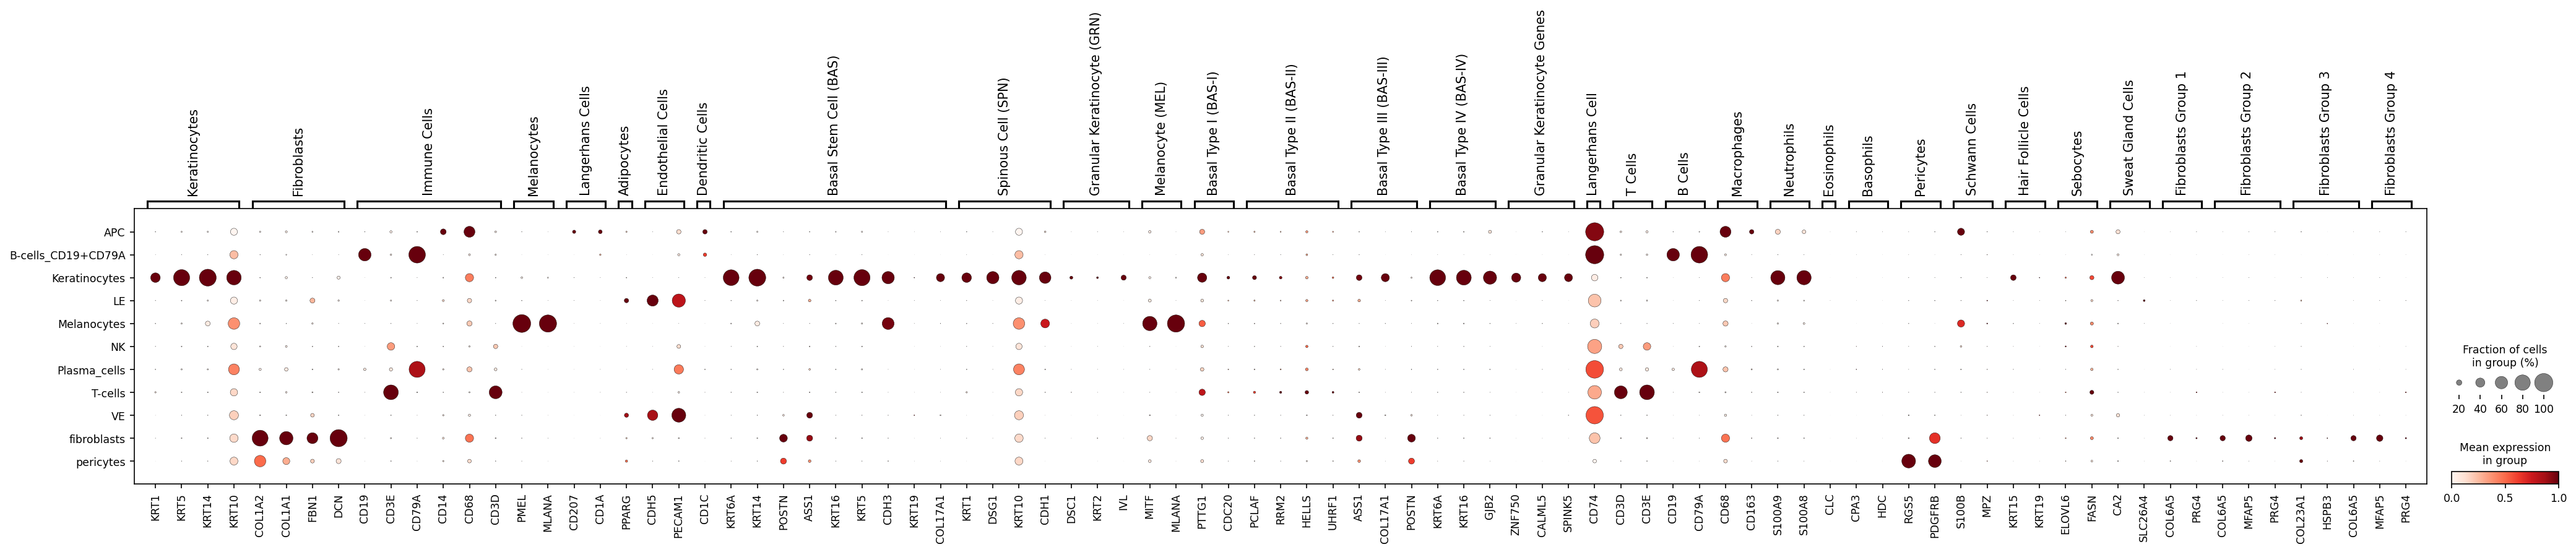

In [39]:
OUTPUTS[fname].show()

### [Conclusions](#menu) <a class="anchor" id="bullet5"></a>

In [40]:
OUTPUTS.keys()

dict_keys(['markers0_broad-ct', 'markers0_broad-ct_scaled-var', 'markers1_broad-ct', 'markers1_broad-ct_scaled-var'])

### [Save](#menu) <a class="anchor" id="bullet6"></a>

In [41]:
for i in [figure_dir, output_dir]:
    if not os.path.isdir(i):
        os.makedirs(i)

In [42]:
pflag = " \033[1;32m√\033[0m"
for filename, item in OUTPUTS.items():
    # output_dir vs figure_dir
    if isinstance(item, (pd.DataFrame, dict)):
        fname = os.path.join(output_dir, f"{filename}")
    else:
        fname = os.path.join(figure_dir, f"{filename}")
    print("Storing", type(item), fname, end="");
    eflag = " \033[1;31mX\033[0m"
    if not os.path.isdir(os.path.dirname(fname)):
        os.makedirs(os.path.dirname(fname)); eflag = pflag
    # file type
    if isinstance(item, (mplfig.Figure, tuple)):
        (item[0] if isinstance(item, tuple) else item).savefig(f"{fname}.png")
        plt.close(); eflag = pflag
    elif isinstance(item, pd.DataFrame):
        item.to_csv(f"{fname}.csv"); eflag = pflag
    elif isinstance(item, dict):
        with open(f"{fname}.pickle", 'wb') as handle:
            pickle.dump(item, handle, protocol=pickle.HIGHEST_PROTOCOL)
        eflag = pflag
    elif item is not None:
        item.savefig(f"{fname}.png")
        plt.close(); eflag = pflag
    print(f"{eflag}")

Storing <class 'scanpy.plotting._dotplot.DotPlot'> figures/atlas_annotation/markers0_broad-ct √
Storing <class 'scanpy.plotting._dotplot.DotPlot'> figures/atlas_annotation/markers0_broad-ct_scaled-var √
Storing <class 'scanpy.plotting._dotplot.DotPlot'> figures/atlas_annotation/markers1_broad-ct √
Storing <class 'scanpy.plotting._dotplot.DotPlot'> figures/atlas_annotation/markers1_broad-ct_scaled-var √


Done.